In [1]:
# Intializing the libraries
import numpy as np
import math
import tensorflow as tf
import h5py
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(0)

### EDA

In [2]:
# Importing the Datasets
Dataset = h5py.File('SVHN_single_grey1.h5','r')
Dataset.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [3]:
# Train Set
X_train = Dataset['X_val'][:]
y_train = Dataset['y_val'][:]

# Test Set
X_test = Dataset['X_test'][:]
y_test = Dataset['y_test'][:]

# Validation Set
X_val = Dataset['X_train'][:]
y_val = Dataset['y_train'][:]

In [4]:
# Checking the shape of the data set
print(X_test.shape)
print(X_train.shape)
print(X_val.shape)

(18000, 32, 32)
(60000, 32, 32)
(42000, 32, 32)


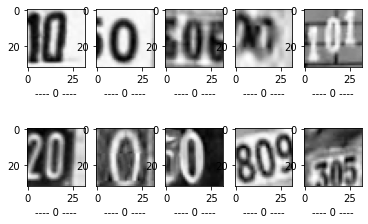

In [5]:
# Visualizing the dataset and labels
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xlabel('---- {0} ----'.format(y_train[i]))
    plt.imshow(X_train[i],cmap='Greys')

### Reshapping and Normalizing the Inputs

In [6]:
# Reshaping the Inputs from (32,32) 2-dimensional to 1-dimensional.
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

In [7]:
# Zero centering the Input space
train_means = np.mean(X_train,axis=0)
for i in range (X_train.shape[0]):
    X_train[i,:] -= train_means
    
for i in range (X_test.shape[0]):
    X_test[i,:] -= train_means

for i in range (X_val.shape[0]):
    X_val[i,:] -= train_means

In [8]:
# Normalizing the Input space
train_devs = np.std(X_train,axis=0)
for i in range (X_train.shape[0]):
    X_train[i,:] /= train_devs
    
for i in range (X_test.shape[0]):
    X_test[i,:] /= train_devs

for i in range (X_val.shape[0]):
    X_val[i,:] /= train_devs

### ONE HOT Encoding the ouput labels

In [9]:
# One hot encoding for labels
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val,num_classes=10)

### Train - Validation - Test Split

In [10]:
#Stacking the complete dataset
X = np.vstack((X_train,X_val,X_test)) 
Y = np.vstack((y_train,y_val,y_test))

In [11]:

from sklearn.model_selection import train_test_split

X_train,x,y_train,y = train_test_split(X,Y,random_state = 7,test_size = 0.4)

X_val,X_test,y_val,y_test = train_test_split(x,y,random_state = 7,test_size = 0.5)

In [12]:
X_train.shape

(72000, 1024)

# Model Intialzation and Hyperparameters Tuning

## Fixing the Model Architecture hyperparameters

In [2]:
# intializing the NN model function
def model_arch(X,Y,loops,learningrate,regularization,hidden_layer_1_neurons,hidden_layer_2_neurons,hidden_layer_3_neurons,
               dropout,val = False,x_val = None,y_val = None):
    # intializing the model
    NN_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_layer_1_neurons),
        tf.keras.layers.Dropout(dropout),  # Dropouts are generally used after Activation functions but it can be used before for relu
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(hidden_layer_2_neurons),
        tf.keras.layers.Dropout(dropout),  # Dropouts are generally used after Activation functions but it can be used before for relu
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(hidden_layer_3_neurons),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(10,activation = 'softmax',kernel_regularizer = tf.keras.regularizers.l2(regularization))
    ])
    
    # Adam Optimizer
    adam = tf.keras.optimizers.Adam(learning_rate= learningrate,beta_1 =0.8 ,beta_2=0.8,decay = 1e-4)
    
    # Compile
    NN_model.compile(optimizer= adam,loss='categorical_crossentropy',metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10 , min_delta = 0.01 )
    
    if val == True:
        NN_model.fit(X,Y,epochs=loops,validation_data=(x_val,y_val),batch_size = int(X.shape[0]/21),callbacks=[callback])
    else:
         NN_model.fit(X,Y,epochs=loops,batch_size = int(X.shape[0]/21))
    
    return(NN_model)
        

### Coarse Search

In [14]:
# Intializing empty lists
Layer_1_neurons=[]
Layer_2_neurons = []
Layer_3_neurons = []
Dropout = []
Loss = []
Accuracy = []

# Tuning
for i in range(15):
    print('--------------------------- Loop {0} ---------------------------'.format(i+1))
    layer_1 = np.random.randint(500,1000)
    layer_2 = np.random.randint(200,500)
    layer_3 = np.random.randint(75,200)
    drop = np.random.uniform(0.2,0.5)
    mod = model_arch(X_train,y_train,loops = 100,hidden_layer_1_neurons= layer_1,hidden_layer_2_neurons= layer_2,hidden_layer_3_neurons= layer_3,
                     dropout=drop,learningrate = 0.01, regularization = 0,val=True,x_val=X_val,y_val=y_val)
    # Performance of model
    loss,accuracy = mod.evaluate(X_val,y_val)
    print('Accuracy on the Validation Data is {0} and the loss is {1}'.format(accuracy,loss))
    print('For Hidden Layer 1 neurons =  {0} ,Hidden Layer 2 neurons =  {1} & Hidden Layer 3 neurons =  {2} ; also Droput of {3}'.format(layer_1,layer_2,layer_3,drop))
    print('\n')
    Layer_1_neurons.append(layer_1)
    Layer_2_neurons.append(layer_2)
    Layer_3_neurons.append(layer_3)
    Dropout.append(drop)
    Loss.append(loss)
    Accuracy.append(accuracy)
    
# Visualizng the Results
data = pd.DataFrame(Layer_1_neurons,columns=['Layer 1 neurons'])
data['Layer 2 neurons'] = Layer_2_neurons
data['Layer 3 neurons'] = Layer_3_neurons
data['Dropout'] = Dropout
data['Loss'] = Loss
data['Accuracy'] = Accuracy

--------------------------- Loop 1 ---------------------------
Epoch 1/100
22/22 [==============================] - 2s 100ms/step - loss: 2.3921 - accuracy: 0.1138 - val_loss: 2.7992 - val_accuracy: 0.1337
Epoch 2/100
22/22 [==============================] - 2s 95ms/step - loss: 2.0467 - accuracy: 0.2429 - val_loss: 1.6941 - val_accuracy: 0.4202
Epoch 3/100
22/22 [==============================] - 2s 96ms/step - loss: 1.4404 - accuracy: 0.5058 - val_loss: 1.4902 - val_accuracy: 0.5867
Epoch 4/100
22/22 [==============================] - 2s 97ms/step - loss: 1.1333 - accuracy: 0.6308 - val_loss: 1.3143 - val_accuracy: 0.6421
Epoch 5/100
22/22 [==============================] - 2s 97ms/step - loss: 1.0426 - accuracy: 0.6619 - val_loss: 1.0999 - val_accuracy: 0.6908
Epoch 6/100
22/22 [==============================] - 2s 96ms/step - loss: 0.9424 - accuracy: 0.6972 - val_loss: 0.9940 - val_accuracy: 0.7268
Epoch 7/100
22/22 [==============================] - 2s 94ms/step - loss: 0.8885 - a

22/22 [==============================] - 3s 114ms/step - loss: 1.0327 - accuracy: 0.6654 - val_loss: 0.9196 - val_accuracy: 0.7444
Epoch 8/100
22/22 [==============================] - 3s 114ms/step - loss: 0.9431 - accuracy: 0.6990 - val_loss: 0.8303 - val_accuracy: 0.7549
Epoch 9/100
22/22 [==============================] - 3s 115ms/step - loss: 0.9131 - accuracy: 0.7100 - val_loss: 0.7772 - val_accuracy: 0.7703
Epoch 10/100
22/22 [==============================] - 3s 116ms/step - loss: 0.8941 - accuracy: 0.7139 - val_loss: 0.7938 - val_accuracy: 0.7500
Epoch 11/100
22/22 [==============================] - 3s 114ms/step - loss: 0.8725 - accuracy: 0.7204 - val_loss: 0.6764 - val_accuracy: 0.7908
Epoch 12/100
22/22 [==============================] - 3s 120ms/step - loss: 0.8688 - accuracy: 0.7238 - val_loss: 0.6708 - val_accuracy: 0.7893
Epoch 13/100
22/22 [==============================] - 3s 115ms/step - loss: 0.8231 - accuracy: 0.7388 - val_loss: 0.7455 - val_accuracy: 0.7615
Epoch 1

Epoch 15/100
22/22 [==============================] - 2s 84ms/step - loss: 0.6858 - accuracy: 0.7810 - val_loss: 0.5445 - val_accuracy: 0.8312
Epoch 16/100
22/22 [==============================] - 2s 82ms/step - loss: 0.7108 - accuracy: 0.7739 - val_loss: 0.5782 - val_accuracy: 0.8207
Epoch 17/100
22/22 [==============================] - 2s 83ms/step - loss: 0.6860 - accuracy: 0.7814 - val_loss: 0.5488 - val_accuracy: 0.8284
Epoch 18/100
22/22 [==============================] - 2s 86ms/step - loss: 0.6763 - accuracy: 0.7855 - val_loss: 0.5491 - val_accuracy: 0.8258
Epoch 19/100
22/22 [==============================] - 2s 88ms/step - loss: 0.6705 - accuracy: 0.7869 - val_loss: 0.5305 - val_accuracy: 0.8337
Epoch 20/100
22/22 [==============================] - 2s 90ms/step - loss: 0.6688 - accuracy: 0.7854 - val_loss: 0.5352 - val_accuracy: 0.8295
Epoch 21/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6375 - accuracy: 0.7968 - val_loss: 0.5087 - val_accuracy: 0.8395

Epoch 26/100
22/22 [==============================] - 2s 95ms/step - loss: 0.6738 - accuracy: 0.7853 - val_loss: 0.4998 - val_accuracy: 0.8440
Epoch 27/100
22/22 [==============================] - 2s 84ms/step - loss: 0.6402 - accuracy: 0.7980 - val_loss: 0.4992 - val_accuracy: 0.8459
Epoch 28/100
22/22 [==============================] - 2s 90ms/step - loss: 0.6505 - accuracy: 0.7938 - val_loss: 0.4977 - val_accuracy: 0.8458
Epoch 29/100
22/22 [==============================] - 2s 88ms/step - loss: 0.6108 - accuracy: 0.8072 - val_loss: 0.4894 - val_accuracy: 0.8475
Epoch 30/100
22/22 [==============================] - 2s 94ms/step - loss: 0.6623 - accuracy: 0.7873 - val_loss: 0.4790 - val_accuracy: 0.8503
Epoch 31/100
22/22 [==============================] - 2s 85ms/step - loss: 0.6075 - accuracy: 0.8077 - val_loss: 0.4987 - val_accuracy: 0.8451
Epoch 32/100
22/22 [==============================] - 2s 90ms/step - loss: 0.6350 - accuracy: 0.7981 - val_loss: 0.4645 - val_accuracy: 0.8562

Epoch 1/100
22/22 [==============================] - 3s 119ms/step - loss: 2.3917 - accuracy: 0.1065 - val_loss: 2.6814 - val_accuracy: 0.1066
Epoch 2/100
22/22 [==============================] - 3s 115ms/step - loss: 2.1042 - accuracy: 0.2126 - val_loss: 1.7858 - val_accuracy: 0.3422
Epoch 3/100
22/22 [==============================] - 2s 112ms/step - loss: 1.5442 - accuracy: 0.4561 - val_loss: 1.4415 - val_accuracy: 0.5572
Epoch 4/100
22/22 [==============================] - 2s 113ms/step - loss: 1.2038 - accuracy: 0.6008 - val_loss: 1.1943 - val_accuracy: 0.6464
Epoch 5/100
22/22 [==============================] - 2s 112ms/step - loss: 1.0535 - accuracy: 0.6603 - val_loss: 1.0882 - val_accuracy: 0.6734
Epoch 6/100
22/22 [==============================] - 2s 113ms/step - loss: 1.0257 - accuracy: 0.6691 - val_loss: 0.8762 - val_accuracy: 0.7440
Epoch 7/100
22/22 [==============================] - 2s 111ms/step - loss: 0.9299 - accuracy: 0.7015 - val_loss: 0.8099 - val_accuracy: 0.7563

22/22 [==============================] - 2s 109ms/step - loss: 0.7008 - accuracy: 0.7759 - val_loss: 0.6903 - val_accuracy: 0.7818
Epoch 16/100
22/22 [==============================] - 2s 109ms/step - loss: 0.6616 - accuracy: 0.7916 - val_loss: 0.5885 - val_accuracy: 0.8171
Epoch 17/100
22/22 [==============================] - 2s 108ms/step - loss: 0.6375 - accuracy: 0.7969 - val_loss: 0.6060 - val_accuracy: 0.8103
Epoch 18/100
22/22 [==============================] - 3s 116ms/step - loss: 0.5900 - accuracy: 0.8129 - val_loss: 0.5415 - val_accuracy: 0.8307
Epoch 19/100
22/22 [==============================] - 2s 105ms/step - loss: 0.5805 - accuracy: 0.8164 - val_loss: 0.5075 - val_accuracy: 0.8433
Epoch 20/100
22/22 [==============================] - 3s 119ms/step - loss: 0.5394 - accuracy: 0.8292 - val_loss: 0.5731 - val_accuracy: 0.8206
Epoch 21/100
22/22 [==============================] - 2s 102ms/step - loss: 0.5713 - accuracy: 0.8173 - val_loss: 0.6135 - val_accuracy: 0.8068
Epoch

22/22 [==============================] - 3s 115ms/step - loss: 0.5782 - accuracy: 0.8161 - val_loss: 0.4794 - val_accuracy: 0.8489
Epoch 27/100
22/22 [==============================] - 3s 115ms/step - loss: 0.5673 - accuracy: 0.8209 - val_loss: 0.4543 - val_accuracy: 0.8588
Epoch 28/100
22/22 [==============================] - 3s 116ms/step - loss: 0.5683 - accuracy: 0.8204 - val_loss: 0.4518 - val_accuracy: 0.8584
Epoch 29/100
22/22 [==============================] - 3s 122ms/step - loss: 0.5751 - accuracy: 0.8181 - val_loss: 0.4752 - val_accuracy: 0.8521
Epoch 30/100
22/22 [==============================] - 3s 119ms/step - loss: 0.5926 - accuracy: 0.8113 - val_loss: 0.4660 - val_accuracy: 0.8530
Epoch 31/100
22/22 [==============================] - 3s 116ms/step - loss: 0.5906 - accuracy: 0.8105 - val_loss: 0.4720 - val_accuracy: 0.8533
Epoch 32/100
22/22 [==============================] - 3s 117ms/step - loss: 0.5833 - accuracy: 0.8133 - val_loss: 0.4489 - val_accuracy: 0.8602
Epoch

Epoch 1/100
22/22 [==============================] - 2s 98ms/step - loss: 2.3909 - accuracy: 0.1081 - val_loss: 2.7318 - val_accuracy: 0.1109
Epoch 2/100
22/22 [==============================] - 2s 89ms/step - loss: 2.0926 - accuracy: 0.2142 - val_loss: 1.7763 - val_accuracy: 0.3815
Epoch 3/100
22/22 [==============================] - 2s 89ms/step - loss: 1.4937 - accuracy: 0.4810 - val_loss: 1.3714 - val_accuracy: 0.6087
Epoch 4/100
22/22 [==============================] - 2s 88ms/step - loss: 1.1648 - accuracy: 0.6161 - val_loss: 1.1976 - val_accuracy: 0.6611
Epoch 5/100
22/22 [==============================] - 2s 98ms/step - loss: 1.0901 - accuracy: 0.6453 - val_loss: 1.0432 - val_accuracy: 0.6952
Epoch 6/100
22/22 [==============================] - 2s 103ms/step - loss: 1.0252 - accuracy: 0.6691 - val_loss: 0.9300 - val_accuracy: 0.7170
Epoch 7/100
22/22 [==============================] - 2s 91ms/step - loss: 0.9315 - accuracy: 0.7005 - val_loss: 0.9377 - val_accuracy: 0.7088
Epoch

In [15]:
data

,Layer 1 neurons,Layer 2 neurons,Layer 3 neurons,Dropout,Loss,Accuracy
0,619,265,166,0.336442,0.375097,0.883375
1,933,331,82,0.449194,0.387654,0.879958
2,938,239,156,0.494664,0.432882,0.866000
3,869,295,189,0.224616,0.345747,0.898917
4,516,346,80,0.429407,0.405519,0.873042
5,539,297,154,0.481109,0.442877,0.861750
6,968,431,121,0.336451,0.364230,0.889042
7,500,434,93,0.365021,0.398763,0.875792
8,796,305,153,0.471532,0.407738,0.873333
9,894,471,150,0.211180,0.372287,0.891125


We will narrow our input parameters as

Layer_1_neurons : 500 - 700

Layer_2_neurons : 350 - 500

Layer_3_neurons : 75 - 150 

Dropout : 0.2 - 0.3

### Fine Search

In [16]:
# Intializing empty lists
Layer_1_neurons=[]
Layer_2_neurons = []
Layer_3_neurons = []
Dropout = []
Loss = []
Accuracy = []

# Tuning
for i in range(10):
    print('--------------------------- Loop {0} ---------------------------'.format(i+1))
    layer_1 = np.random.randint(500,700)
    layer_2 = np.random.randint(350,500)
    layer_3 = np.random.randint(75,150)
    drop = np.random.uniform(0.2,0.3)
    mod = model_arch(X_train,y_train,loops = 100,hidden_layer_1_neurons= layer_1,hidden_layer_2_neurons= layer_2,hidden_layer_3_neurons= layer_3,
                     dropout=drop,learningrate = 0.01, regularization = 0,val=True,x_val=X_val,y_val=y_val)
    # Performance of model
    loss,accuracy = mod.evaluate(X_val,y_val)
    print('Accuracy on the Validation Data is {0} and the loss is {1}'.format(accuracy,loss))
    print('For Hidden Layer 1 neurons =  {0} ,Hidden Layer 2 neurons =  {1} & Hidden Layer 3 neurons =  {2} ; also Droput of {3}'.format(layer_1,layer_2,layer_3,drop))
    print('\n')
    Layer_1_neurons.append(layer_1)
    Layer_2_neurons.append(layer_2)
    Layer_3_neurons.append(layer_3)
    Dropout.append(drop)
    Loss.append(loss)
    Accuracy.append(accuracy)
    
# Visualizng the Results
data = pd.DataFrame(Layer_1_neurons,columns=['Layer 1 neurons'])
data['Layer 2 neurons'] = Layer_2_neurons
data['Layer 3 neurons'] = Layer_3_neurons
data['Dropout'] = Dropout
data['Loss'] = Loss
data['Accuracy'] = Accuracy

--------------------------- Loop 1 ---------------------------
Epoch 1/100
22/22 [==============================] - 3s 116ms/step - loss: 2.3984 - accuracy: 0.1097 - val_loss: 3.0607 - val_accuracy: 0.1085
Epoch 2/100
22/22 [==============================] - 2s 102ms/step - loss: 2.0806 - accuracy: 0.2309 - val_loss: 1.8125 - val_accuracy: 0.3283
Epoch 3/100
22/22 [==============================] - 2s 96ms/step - loss: 1.4574 - accuracy: 0.4907 - val_loss: 1.5566 - val_accuracy: 0.5281
Epoch 4/100
22/22 [==============================] - 2s 97ms/step - loss: 1.1487 - accuracy: 0.6233 - val_loss: 1.3795 - val_accuracy: 0.6365
Epoch 5/100
22/22 [==============================] - ETA: 0s - loss: 0.9595 - accuracy: 0.69 - 2s 92ms/step - loss: 0.9595 - accuracy: 0.6910 - val_loss: 1.2362 - val_accuracy: 0.6850
Epoch 6/100
22/22 [==============================] - 2s 92ms/step - loss: 0.9155 - accuracy: 0.7058 - val_loss: 1.0523 - val_accuracy: 0.7312
Epoch 7/100
22/22 [======================

22/22 [==============================] - 2s 91ms/step - loss: 0.6826 - accuracy: 0.7837 - val_loss: 0.8762 - val_accuracy: 0.7653
Epoch 11/100
22/22 [==============================] - 2s 91ms/step - loss: 0.6887 - accuracy: 0.7807 - val_loss: 0.8094 - val_accuracy: 0.7757
Epoch 12/100
22/22 [==============================] - 2s 91ms/step - loss: 0.6542 - accuracy: 0.7931 - val_loss: 0.7128 - val_accuracy: 0.7917
Epoch 13/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6398 - accuracy: 0.7966 - val_loss: 0.6509 - val_accuracy: 0.8117
Epoch 14/100
22/22 [==============================] - 2s 91ms/step - loss: 0.6182 - accuracy: 0.8029 - val_loss: 0.6624 - val_accuracy: 0.7953
Epoch 15/100
22/22 [==============================] - 2s 92ms/step - loss: 0.5658 - accuracy: 0.8199 - val_loss: 0.6102 - val_accuracy: 0.8053
Epoch 16/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6155 - accuracy: 0.8016 - val_loss: 0.5872 - val_accuracy: 0.8169
Epoch 17/100

Epoch 11/100
22/22 [==============================] - 2s 86ms/step - loss: 0.7043 - accuracy: 0.7753 - val_loss: 0.9305 - val_accuracy: 0.7605
Epoch 12/100
22/22 [==============================] - 2s 87ms/step - loss: 0.6547 - accuracy: 0.7892 - val_loss: 0.8045 - val_accuracy: 0.7853
Epoch 13/100
22/22 [==============================] - 2s 86ms/step - loss: 0.6027 - accuracy: 0.8083 - val_loss: 0.7196 - val_accuracy: 0.8111
Epoch 14/100
22/22 [==============================] - 2s 88ms/step - loss: 0.5790 - accuracy: 0.8143 - val_loss: 0.7018 - val_accuracy: 0.8031
Epoch 15/100
22/22 [==============================] - 2s 87ms/step - loss: 0.5657 - accuracy: 0.8203 - val_loss: 0.6260 - val_accuracy: 0.8091
Epoch 16/100
22/22 [==============================] - 2s 86ms/step - loss: 0.5422 - accuracy: 0.8279 - val_loss: 0.6276 - val_accuracy: 0.8046
Epoch 17/100
22/22 [==============================] - 2s 88ms/step - loss: 0.5937 - accuracy: 0.8089 - val_loss: 0.5511 - val_accuracy: 0.8313

22/22 [==============================] - 2s 101ms/step - loss: 0.5960 - accuracy: 0.8098 - val_loss: 0.5668 - val_accuracy: 0.8288
Epoch 14/100
22/22 [==============================] - 2s 101ms/step - loss: 0.6108 - accuracy: 0.8039 - val_loss: 0.5925 - val_accuracy: 0.8162
Epoch 15/100
22/22 [==============================] - 2s 101ms/step - loss: 0.5832 - accuracy: 0.8140 - val_loss: 0.5681 - val_accuracy: 0.8210
Epoch 16/100
22/22 [==============================] - 2s 102ms/step - loss: 0.5411 - accuracy: 0.8266 - val_loss: 0.5399 - val_accuracy: 0.8292
Epoch 17/100
22/22 [==============================] - 2s 109ms/step - loss: 0.5843 - accuracy: 0.8123 - val_loss: 0.5146 - val_accuracy: 0.8378
Epoch 18/100
22/22 [==============================] - 3s 114ms/step - loss: 0.5580 - accuracy: 0.8208 - val_loss: 0.5031 - val_accuracy: 0.8460
Epoch 19/100
22/22 [==============================] - 3s 121ms/step - loss: 0.5130 - accuracy: 0.8368 - val_loss: 0.4823 - val_accuracy: 0.8505
Epoch

22/22 [==============================] - 2s 109ms/step - loss: 0.4455 - accuracy: 0.8571 - val_loss: 0.4221 - val_accuracy: 0.8684
Epoch 26/100
22/22 [==============================] - 3s 123ms/step - loss: 0.4398 - accuracy: 0.8583 - val_loss: 0.4244 - val_accuracy: 0.8699
Epoch 27/100
22/22 [==============================] - 2s 102ms/step - loss: 0.4725 - accuracy: 0.8479 - val_loss: 0.4277 - val_accuracy: 0.8662
Epoch 28/100
22/22 [==============================] - 2s 110ms/step - loss: 0.4148 - accuracy: 0.8665 - val_loss: 0.4164 - val_accuracy: 0.8707
Epoch 29/100
22/22 [==============================] - 2s 105ms/step - loss: 0.4017 - accuracy: 0.8714 - val_loss: 0.4154 - val_accuracy: 0.8723
Epoch 30/100
22/22 [==============================] - 2s 107ms/step - loss: 0.3905 - accuracy: 0.8749 - val_loss: 0.4153 - val_accuracy: 0.8716
Epoch 31/100
22/22 [==============================] - 2s 109ms/step - loss: 0.4551 - accuracy: 0.8538 - val_loss: 0.3949 - val_accuracy: 0.8770
Epoch

22/22 [==============================] - 2s 112ms/step - loss: 0.3968 - accuracy: 0.8707 - val_loss: 0.3962 - val_accuracy: 0.8781
Epoch 33/100
22/22 [==============================] - 2s 112ms/step - loss: 0.3923 - accuracy: 0.8730 - val_loss: 0.4017 - val_accuracy: 0.8751
Epoch 34/100
22/22 [==============================] - 2s 114ms/step - loss: 0.3900 - accuracy: 0.8729 - val_loss: 0.3726 - val_accuracy: 0.8846
Epoch 35/100
22/22 [==============================] - 2s 111ms/step - loss: 0.3573 - accuracy: 0.8842 - val_loss: 0.4127 - val_accuracy: 0.8753
Epoch 36/100
22/22 [==============================] - 2s 110ms/step - loss: 0.3588 - accuracy: 0.8831 - val_loss: 0.4204 - val_accuracy: 0.8743
Epoch 37/100
22/22 [==============================] - 2s 112ms/step - loss: 0.3669 - accuracy: 0.8818 - val_loss: 0.3621 - val_accuracy: 0.8906
Epoch 38/100
22/22 [==============================] - 2s 112ms/step - loss: 0.3681 - accuracy: 0.8799 - val_loss: 0.3640 - val_accuracy: 0.8892
Epoch

In [17]:
data

,Layer 1 neurons,Layer 2 neurons,Layer 3 neurons,Dropout,Loss,Accuracy
0,519,424,142,0.222203,0.323804,0.905875
1,573,483,102,0.208721,0.380555,0.884250
2,581,391,106,0.213650,0.333982,0.902292
3,512,405,145,0.203822,0.335400,0.905250
4,657,465,95,0.273805,0.350440,0.894250
5,659,372,146,0.272725,0.324060,0.901458
6,558,360,98,0.213041,0.384480,0.883542
7,602,465,98,0.260169,0.336149,0.898875
8,684,364,108,0.219705,0.362038,0.892875
9,675,476,135,0.271920,0.343510,0.897667


We will be choosing following valuesof architectural hyperparameters

Number of neurons in Layer 1 = 520

Number of neurons in Layer 2 = 420
 
Number of neurons in Layer 3 = 142

Dropout = 0.22

## Learning rate and regularization tuning

In [31]:
# intializing the NN model function
def model(X,Y,loops,learningrate,regularization,val = False,x_val = None,y_val = None,Test = False,x_test= None,y_test =None):
    # intializing the model
    NN_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(520),
        tf.keras.layers.Dropout(0.22),  # Dropouts are generally used after Activation functions but it can be used before for relu
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(420),
        tf.keras.layers.Dropout(0.22),  # Dropouts are generally used after Activation functions but it can be used before for relu
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(142),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(10,activation = 'softmax',kernel_regularizer = tf.keras.regularizers.l2(regularization))
    ])
    
    # Adam Optimizer
    adam = tf.keras.optimizers.Adam(learning_rate= learningrate,beta_1 =0.8 ,beta_2=0.89,decay = 1e-4)
    
    # Compile
    NN_model.compile(optimizer= adam,loss='categorical_crossentropy',metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10 , min_delta = 0.01 )
    
    if val == True:
        NN_model.fit(X,Y,epochs=loops,validation_data=(x_val,y_val),batch_size = int(X.shape[0]/21),callbacks=[callback])
    else:
         NN_model.fit(X,Y,epochs=loops,batch_size = int(X.shape[0]/21))
    
    return(NN_model)

### Checking the Model for Resonability

In [32]:
model(X_train,y_train,loops = 1,learningrate = 0.01, regularization = 0)

22/22 [==============================] - 2s 89ms/step - loss: 2.4116 - accuracy: 0.1028


The initial accuracy of the model is around 10% percent which signifies there is no bias in the model.

### Checking for Loss (Increasing Regularization)

In [33]:
model(X_train,y_train,loops = 1,learningrate = 0.01, regularization = 1e6)

22/22 [==============================] - 2s 88ms/step - loss: 5075112.5000 - accuracy: 0.1040


The Loss is shooting up. Verified.

### Checking if the Network is overfitting on small sub set

In [34]:
X_train_subset = X_train[:100,:]
y_train_subset = y_train[:100,:]

In [35]:
mod = model(X_train_subset,y_train_subset,loops = 200,learningrate = 0.01, regularization = 0)
mod.evaluate(X_train_subset,y_train_subset)

Epoch 1/200
25/25 [==============================] - 0s 4ms/step - loss: 3.2583 - accuracy: 0.1100
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 2.5154 - accuracy: 0.1300
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 2.5270 - accuracy: 0.1300
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 2.5656 - accuracy: 0.1200
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 2.3821 - accuracy: 0.2100
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 2.4239 - accuracy: 0.2400
Epoch 7/200
25/25 [==============================] - 0s 4ms/step - loss: 2.2423 - accuracy: 0.2300
Epoch 8/200
25/25 [==============================] - 0s 4ms/step - loss: 2.1074 - accuracy: 0.3200
Epoch 9/200
25/25 [==============================] - 0s 4ms/step - loss: 1.8970 - accuracy: 0.3400
Epoch 10/200
25/25 [==============================] - 0s 4ms/step - loss: 2.0163 - accuracy: 0.3200
Epoch 11/

25/25 [==============================] - 0s 4ms/step - loss: 0.2456 - accuracy: 0.9200
Epoch 164/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1546 - accuracy: 0.9200
Epoch 165/200
25/25 [==============================] - 0s 4ms/step - loss: 0.5258 - accuracy: 0.8900
Epoch 166/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2686 - accuracy: 0.9500
Epoch 167/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4131 - accuracy: 0.8700
Epoch 168/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1485 - accuracy: 0.9300
Epoch 169/200
25/25 [==============================] - 0s 5ms/step - loss: 0.4265 - accuracy: 0.9300
Epoch 170/200
25/25 [==============================] - 0s 5ms/step - loss: 0.3201 - accuracy: 0.9400
Epoch 171/200
25/25 [==============================] - 0s 4ms/step - loss: 0.3943 - accuracy: 0.9400
Epoch 172/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.9900
Epoc

[0.0005706765223294497, 1.0]

The model is perfectly overfitting the small dataset.
Thus there is no problems in model architecture

### Coarse Hyperparameter Search

In [36]:
# Intializing Lists
Learning_rate = []
Lamda = []
Loss = []
Accuracy = []

# Tunning
for i in range(10):
    print('--------------------------- Loop {0} ---------------------------'.format(i+1))
    lr = math.pow(10,np.random.uniform(-4,-1))
    lamda = math.pow(10,np.random.uniform(-5,1))
    mod = model(X_train,y_train,loops= 100, learningrate= lr,regularization=lamda,val=True,x_val=X_val,y_val=y_val)
    loss,accuracy = mod.evaluate(X_val,y_val)
    
    Learning_rate.append(lr)
    Lamda.append(lamda)
    Loss.append(loss)
    Accuracy.append(accuracy)
    
    print('Accuracy on the Validation Data is {0} and the loss is {1}'.format(accuracy,loss))
    print('For Learning Rate of {0} and Regularization of {1}'.format(lr,lamda))
    print('\n')
    
# Visualizng the Results
data = pd.DataFrame(Learning_rate,columns=['Learning Rate'])
data['Lamda'] = Lamda
data['Loss'] = Loss
data['Accuracy'] = Accuracy

--------------------------- Loop 1 ---------------------------
Epoch 1/100
22/22 [==============================] - 2s 100ms/step - loss: 51.2035 - accuracy: 0.2499 - val_loss: 36.7299 - val_accuracy: 0.5229
Epoch 2/100
22/22 [==============================] - 2s 98ms/step - loss: 28.0105 - accuracy: 0.5972 - val_loss: 19.1699 - val_accuracy: 0.6563
Epoch 3/100
22/22 [==============================] - 2s 100ms/step - loss: 13.9931 - accuracy: 0.6758 - val_loss: 8.8876 - val_accuracy: 0.7211
Epoch 4/100
22/22 [==============================] - 2s 95ms/step - loss: 6.2393 - accuracy: 0.7179 - val_loss: 3.8465 - val_accuracy: 0.7057
Epoch 5/100
22/22 [==============================] - 2s 110ms/step - loss: 2.9187 - accuracy: 0.7221 - val_loss: 2.1370 - val_accuracy: 0.6940
Epoch 6/100
22/22 [==============================] - 3s 114ms/step - loss: 2.0454 - accuracy: 0.7320 - val_loss: 1.8788 - val_accuracy: 0.7052
Epoch 7/100
22/22 [==============================] - 2s 109ms/step - loss: 1

22/22 [==============================] - 2s 88ms/step - loss: 1.2477 - accuracy: 0.6485 - val_loss: 1.1791 - val_accuracy: 0.7135
Epoch 5/100
22/22 [==============================] - 2s 89ms/step - loss: 1.1445 - accuracy: 0.6826 - val_loss: 1.0884 - val_accuracy: 0.7361
Epoch 6/100
22/22 [==============================] - 2s 88ms/step - loss: 1.0797 - accuracy: 0.7023 - val_loss: 1.0113 - val_accuracy: 0.7522
Epoch 7/100
22/22 [==============================] - 2s 88ms/step - loss: 0.9844 - accuracy: 0.7318 - val_loss: 0.9423 - val_accuracy: 0.7751
Epoch 8/100
22/22 [==============================] - 2s 89ms/step - loss: 0.9241 - accuracy: 0.7508 - val_loss: 0.8890 - val_accuracy: 0.7845
Epoch 9/100
22/22 [==============================] - 2s 88ms/step - loss: 0.9023 - accuracy: 0.7554 - val_loss: 0.8332 - val_accuracy: 0.7943
Epoch 10/100
22/22 [==============================] - 2s 89ms/step - loss: 0.8393 - accuracy: 0.7769 - val_loss: 0.8026 - val_accuracy: 0.8002
Epoch 11/100
22/2

22/22 [==============================] - 2s 94ms/step - loss: 0.6722 - accuracy: 0.7925 - val_loss: 0.5991 - val_accuracy: 0.8181
Epoch 22/100
22/22 [==============================] - 2s 94ms/step - loss: 0.6106 - accuracy: 0.8122 - val_loss: 0.6033 - val_accuracy: 0.8163
Epoch 23/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6107 - accuracy: 0.8125 - val_loss: 0.6574 - val_accuracy: 0.8012
Epoch 24/100
22/22 [==============================] - 2s 95ms/step - loss: 0.6065 - accuracy: 0.8138 - val_loss: 0.5838 - val_accuracy: 0.8247
Epoch 25/100
22/22 [==============================] - 2s 94ms/step - loss: 0.5833 - accuracy: 0.8206 - val_loss: 0.5549 - val_accuracy: 0.8320
Epoch 26/100
22/22 [==============================] - 2s 93ms/step - loss: 0.5792 - accuracy: 0.8236 - val_loss: 0.6529 - val_accuracy: 0.8085
Epoch 27/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6168 - accuracy: 0.8098 - val_loss: 0.5408 - val_accuracy: 0.8373
Epoch 28/100

Epoch 18/100
22/22 [==============================] - 2s 93ms/step - loss: 2.7960 - accuracy: 0.7176 - val_loss: 2.6991 - val_accuracy: 0.7522
Epoch 19/100
22/22 [==============================] - 2s 93ms/step - loss: 2.7166 - accuracy: 0.7222 - val_loss: 2.6153 - val_accuracy: 0.7577
Epoch 20/100
22/22 [==============================] - 2s 94ms/step - loss: 2.6281 - accuracy: 0.7316 - val_loss: 2.5320 - val_accuracy: 0.7617
Epoch 21/100
22/22 [==============================] - 2s 94ms/step - loss: 2.5516 - accuracy: 0.7368 - val_loss: 2.4560 - val_accuracy: 0.7637
Epoch 22/100
22/22 [==============================] - 2s 93ms/step - loss: 2.4764 - accuracy: 0.7400 - val_loss: 2.3797 - val_accuracy: 0.7689
Epoch 23/100
22/22 [==============================] - 2s 94ms/step - loss: 2.4068 - accuracy: 0.7451 - val_loss: 2.3086 - val_accuracy: 0.7716
Epoch 24/100
22/22 [==============================] - 2s 94ms/step - loss: 2.3397 - accuracy: 0.7490 - val_loss: 2.2412 - val_accuracy: 0.7744

22/22 [==============================] - 2s 93ms/step - loss: 1.0956 - accuracy: 0.8043 - val_loss: 1.1130 - val_accuracy: 0.7876
Epoch 14/100
22/22 [==============================] - 2s 94ms/step - loss: 1.0710 - accuracy: 0.8084 - val_loss: 1.0792 - val_accuracy: 0.7978
Epoch 15/100
22/22 [==============================] - 2s 93ms/step - loss: 1.0980 - accuracy: 0.7944 - val_loss: 0.9587 - val_accuracy: 0.8313
Epoch 16/100
22/22 [==============================] - 2s 94ms/step - loss: 0.9851 - accuracy: 0.8319 - val_loss: 1.0980 - val_accuracy: 0.7922
Epoch 17/100
22/22 [==============================] - 2s 94ms/step - loss: 1.0666 - accuracy: 0.7980 - val_loss: 0.9701 - val_accuracy: 0.8108
Epoch 18/100
22/22 [==============================] - 2s 94ms/step - loss: 0.9576 - accuracy: 0.8323 - val_loss: 1.0052 - val_accuracy: 0.8057
Epoch 19/100
22/22 [==============================] - 2s 94ms/step - loss: 0.9378 - accuracy: 0.8347 - val_loss: 0.9239 - val_accuracy: 0.8400
Epoch 20/100

22/22 [==============================] - 2s 96ms/step - loss: 1.4551 - accuracy: 0.8569 - val_loss: 1.5249 - val_accuracy: 0.8503
Epoch 28/100
22/22 [==============================] - 2s 95ms/step - loss: 1.4388 - accuracy: 0.8597 - val_loss: 1.5367 - val_accuracy: 0.8324
Epoch 29/100
22/22 [==============================] - 2s 95ms/step - loss: 1.4453 - accuracy: 0.8502 - val_loss: 1.5163 - val_accuracy: 0.8517
Epoch 30/100
22/22 [==============================] - 2s 93ms/step - loss: 1.4053 - accuracy: 0.8639 - val_loss: 1.4945 - val_accuracy: 0.8521
Epoch 31/100
22/22 [==============================] - 2s 96ms/step - loss: 1.3978 - accuracy: 0.8626 - val_loss: 1.4560 - val_accuracy: 0.8575
Epoch 32/100
22/22 [==============================] - 2s 94ms/step - loss: 1.3844 - accuracy: 0.8625 - val_loss: 1.4255 - val_accuracy: 0.8629
Epoch 33/100
22/22 [==============================] - 2s 95ms/step - loss: 1.3605 - accuracy: 0.8691 - val_loss: 1.4207 - val_accuracy: 0.8574
Epoch 34/100

In [37]:
data

,Learning Rate,Lamda,Loss,Accuracy
0,0.001597,3.343623,1.190717,0.864458
1,0.001530,0.001214,0.459227,0.871083
2,0.010812,0.000301,0.453062,0.863417
3,0.000393,0.005411,0.459441,0.885250
4,0.004613,0.070393,0.459106,0.880583
5,0.032525,0.000257,0.394668,0.886917
6,0.000100,0.171647,1.006751,0.843750
7,0.009361,0.000784,0.381498,0.891708
8,0.001392,0.438158,0.681273,0.877292
9,0.001027,3.212103,1.299306,0.872458


According the Table above we will set the parameters window as below 

Learning rate : 1e-4 to 1e-1

Lamda         : 1e-7 to 1e-3

### Fine Hyperparameters search

In [38]:
# Intializing Lists
Learning_rate = []
Lamda = []
Loss = []
Accuracy = []

for i in range(10):
    print('--------------------------- Loop {0} ---------------------------'.format(i+1))
    lr = math.pow(10,np.random.uniform(-4,-1))
    lamda = math.pow(10,np.random.uniform(-7,-3))
    mod = model(X_train,y_train,loops= 100, learningrate= lr,regularization=lamda,val=True,x_val=X_val,y_val=y_val)
    loss,accuracy = mod.evaluate(X_val,y_val)
    
    Learning_rate.append(lr)
    Lamda.append(lamda)
    Loss.append(loss)
    Accuracy.append(accuracy)
    
    print('Accuracy on the Validation Data is {0} and the loss is {1}'.format(accuracy,loss))
    print('For Learning Rate of {0} and Regularization of {1}'.format(lr,lamda))
    print('\n')
    
# Visualizng the Results
data = pd.DataFrame(Learning_rate,columns=['Learning Rate'])
data['Lamda'] = Lamda
data['Loss'] = Loss
data['Accuracy'] = Accuracy

--------------------------- Loop 1 ---------------------------
Epoch 1/100
22/22 [==============================] - 2s 102ms/step - loss: 2.4534 - accuracy: 0.1075 - val_loss: 3.0093 - val_accuracy: 0.1033
Epoch 2/100
22/22 [==============================] - 2s 95ms/step - loss: 2.2672 - accuracy: 0.1410 - val_loss: 2.1139 - val_accuracy: 0.1763
Epoch 3/100
22/22 [==============================] - 2s 94ms/step - loss: 1.8019 - accuracy: 0.3422 - val_loss: 1.7447 - val_accuracy: 0.4112
Epoch 4/100
22/22 [==============================] - 2s 93ms/step - loss: 1.4333 - accuracy: 0.5086 - val_loss: 1.5275 - val_accuracy: 0.5177
Epoch 5/100
22/22 [==============================] - 2s 93ms/step - loss: 1.1299 - accuracy: 0.6298 - val_loss: 1.5145 - val_accuracy: 0.5472
Epoch 6/100
22/22 [==============================] - 2s 95ms/step - loss: 1.0458 - accuracy: 0.6611 - val_loss: 1.3339 - val_accuracy: 0.6158
Epoch 7/100
22/22 [==============================] - 2s 93ms/step - loss: 0.9743 - a

Epoch 13/100
22/22 [==============================] - 2s 93ms/step - loss: 0.7270 - accuracy: 0.7685 - val_loss: 0.7740 - val_accuracy: 0.7620
Epoch 14/100
22/22 [==============================] - 2s 94ms/step - loss: 0.7018 - accuracy: 0.7761 - val_loss: 0.7420 - val_accuracy: 0.7668
Epoch 15/100
22/22 [==============================] - 2s 95ms/step - loss: 0.6769 - accuracy: 0.7841 - val_loss: 0.6377 - val_accuracy: 0.7993
Epoch 16/100
22/22 [==============================] - 2s 94ms/step - loss: 0.6096 - accuracy: 0.8048 - val_loss: 0.6927 - val_accuracy: 0.7810
Epoch 17/100
22/22 [==============================] - 2s 95ms/step - loss: 0.6372 - accuracy: 0.7959 - val_loss: 0.6345 - val_accuracy: 0.8032
Epoch 18/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6358 - accuracy: 0.7969 - val_loss: 0.5678 - val_accuracy: 0.8225
Epoch 19/100
22/22 [==============================] - 2s 93ms/step - loss: 0.5384 - accuracy: 0.8279 - val_loss: 0.5446 - val_accuracy: 0.8282

22/22 [==============================] - 2s 95ms/step - loss: 0.5813 - accuracy: 0.8183 - val_loss: 0.5471 - val_accuracy: 0.8342
Epoch 23/100
22/22 [==============================] - 2s 94ms/step - loss: 0.5201 - accuracy: 0.8388 - val_loss: 0.5536 - val_accuracy: 0.8322
Epoch 24/100
22/22 [==============================] - 2s 95ms/step - loss: 0.5285 - accuracy: 0.8367 - val_loss: 0.5871 - val_accuracy: 0.8237
Epoch 25/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6189 - accuracy: 0.8059 - val_loss: 0.5419 - val_accuracy: 0.8410
Epoch 26/100
22/22 [==============================] - 2s 95ms/step - loss: 0.5255 - accuracy: 0.8371 - val_loss: 0.5362 - val_accuracy: 0.8335
Epoch 27/100
22/22 [==============================] - 2s 95ms/step - loss: 0.5528 - accuracy: 0.8264 - val_loss: 0.4971 - val_accuracy: 0.8485
Epoch 28/100
22/22 [==============================] - 2s 94ms/step - loss: 0.5150 - accuracy: 0.8415 - val_loss: 0.5310 - val_accuracy: 0.8410
Epoch 29/100

22/22 [==============================] - 2s 96ms/step - loss: 0.6707 - accuracy: 0.7926 - val_loss: 0.6715 - val_accuracy: 0.7921
Epoch 16/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6406 - accuracy: 0.8028 - val_loss: 0.6317 - val_accuracy: 0.8096
Epoch 17/100
22/22 [==============================] - 2s 95ms/step - loss: 0.6315 - accuracy: 0.8056 - val_loss: 0.5660 - val_accuracy: 0.8298
Epoch 18/100
22/22 [==============================] - 2s 96ms/step - loss: 0.5932 - accuracy: 0.8191 - val_loss: 0.5888 - val_accuracy: 0.8255
Epoch 19/100
22/22 [==============================] - 2s 97ms/step - loss: 0.5941 - accuracy: 0.8175 - val_loss: 0.5919 - val_accuracy: 0.8192
Epoch 20/100
22/22 [==============================] - 2s 95ms/step - loss: 0.5966 - accuracy: 0.8186 - val_loss: 0.5565 - val_accuracy: 0.8315
Epoch 21/100
22/22 [==============================] - 2s 95ms/step - loss: 0.5862 - accuracy: 0.8211 - val_loss: 0.5315 - val_accuracy: 0.8428
Epoch 22/100

22/22 [==============================] - 2s 97ms/step - loss: 0.5613 - accuracy: 0.8215 - val_loss: 0.5768 - val_accuracy: 0.8207
Epoch 22/100
22/22 [==============================] - 2s 95ms/step - loss: 0.5975 - accuracy: 0.8113 - val_loss: 0.5699 - val_accuracy: 0.8268
Epoch 23/100
22/22 [==============================] - 2s 94ms/step - loss: 0.6172 - accuracy: 0.8034 - val_loss: 0.6733 - val_accuracy: 0.8002
Epoch 24/100
22/22 [==============================] - 2s 94ms/step - loss: 0.6274 - accuracy: 0.8007 - val_loss: 0.5780 - val_accuracy: 0.8248
Epoch 25/100
22/22 [==============================] - 2s 94ms/step - loss: 0.5748 - accuracy: 0.8167 - val_loss: 0.5917 - val_accuracy: 0.8210
Epoch 26/100
22/22 [==============================] - 2s 94ms/step - loss: 0.5746 - accuracy: 0.8187 - val_loss: 0.5446 - val_accuracy: 0.8317
Epoch 27/100
22/22 [==============================] - 2s 95ms/step - loss: 0.5589 - accuracy: 0.8211 - val_loss: 0.5734 - val_accuracy: 0.8227
Epoch 28/100

Epoch 17/100
22/22 [==============================] - 2s 92ms/step - loss: 0.7179 - accuracy: 0.7750 - val_loss: 0.7053 - val_accuracy: 0.7812
Epoch 18/100
22/22 [==============================] - 2s 93ms/step - loss: 0.7413 - accuracy: 0.7677 - val_loss: 0.7335 - val_accuracy: 0.7715
Epoch 19/100
22/22 [==============================] - 2s 94ms/step - loss: 0.7041 - accuracy: 0.7803 - val_loss: 0.6551 - val_accuracy: 0.7974
Epoch 20/100
22/22 [==============================] - 2s 95ms/step - loss: 0.7382 - accuracy: 0.7672 - val_loss: 0.6927 - val_accuracy: 0.7903
Epoch 21/100
22/22 [==============================] - 2s 94ms/step - loss: 0.6476 - accuracy: 0.7970 - val_loss: 0.7020 - val_accuracy: 0.7855
Epoch 22/100
22/22 [==============================] - 2s 93ms/step - loss: 0.6696 - accuracy: 0.7888 - val_loss: 0.6165 - val_accuracy: 0.8110
Epoch 23/100
22/22 [==============================] - 2s 96ms/step - loss: 0.6321 - accuracy: 0.8030 - val_loss: 0.6115 - val_accuracy: 0.8110

22/22 [==============================] - 2s 94ms/step - loss: 0.5386 - accuracy: 0.8290 - val_loss: 0.5677 - val_accuracy: 0.8260
Epoch 18/100
22/22 [==============================] - 2s 94ms/step - loss: 0.5764 - accuracy: 0.8164 - val_loss: 0.4933 - val_accuracy: 0.8448
Epoch 19/100
22/22 [==============================] - 2s 93ms/step - loss: 0.4851 - accuracy: 0.8450 - val_loss: 0.5374 - val_accuracy: 0.8297
Epoch 20/100
22/22 [==============================] - 2s 93ms/step - loss: 0.5346 - accuracy: 0.8294 - val_loss: 0.5406 - val_accuracy: 0.8369
Epoch 21/100
22/22 [==============================] - 2s 94ms/step - loss: 0.4736 - accuracy: 0.8496 - val_loss: 0.5128 - val_accuracy: 0.8410
Epoch 22/100
22/22 [==============================] - 2s 93ms/step - loss: 0.4807 - accuracy: 0.8465 - val_loss: 0.4666 - val_accuracy: 0.8580
Epoch 23/100
22/22 [==============================] - 2s 93ms/step - loss: 0.4496 - accuracy: 0.8577 - val_loss: 0.4830 - val_accuracy: 0.8496
Epoch 24/100

Epoch 32/100
22/22 [==============================] - 2s 93ms/step - loss: 0.4859 - accuracy: 0.8465 - val_loss: 0.4728 - val_accuracy: 0.8535
Epoch 33/100
22/22 [==============================] - 2s 94ms/step - loss: 0.4851 - accuracy: 0.8480 - val_loss: 0.5022 - val_accuracy: 0.8466
Epoch 34/100
22/22 [==============================] - 2s 93ms/step - loss: 0.4986 - accuracy: 0.8427 - val_loss: 0.4921 - val_accuracy: 0.8523
Epoch 35/100
22/22 [==============================] - 2s 95ms/step - loss: 0.4899 - accuracy: 0.8460 - val_loss: 0.4884 - val_accuracy: 0.8455
Epoch 36/100
22/22 [==============================] - 2s 95ms/step - loss: 0.4866 - accuracy: 0.8454 - val_loss: 0.4741 - val_accuracy: 0.8545
Epoch 37/100
22/22 [==============================] - 2s 96ms/step - loss: 0.4744 - accuracy: 0.8498 - val_loss: 0.4581 - val_accuracy: 0.8598
Epoch 38/100
22/22 [==============================] - 2s 93ms/step - loss: 0.4501 - accuracy: 0.8573 - val_loss: 0.4517 - val_accuracy: 0.8620

In [39]:
data

,Learning Rate,Lamda,Loss,Accuracy
0,0.015952,1.239340e-06,0.394768,0.878833
1,0.024122,3.592824e-07,0.460545,0.865667
2,0.029484,9.377867e-05,0.376368,0.891292
3,0.000186,8.783137e-05,0.414867,0.876958
4,0.014446,9.925973e-04,0.387904,0.887833
5,0.006050,6.933747e-07,0.340761,0.898917
6,0.041719,5.356941e-06,0.397616,0.881083
7,0.057285,5.232142e-05,0.403597,0.876583
8,0.006343,1.119485e-05,0.413808,0.879042
9,0.060947,3.115934e-06,0.422931,0.870958


From the above table we see that the values of

<b>Learning rate = 0.003
Lamda         = 6.933747e-07</b>

Would provide the maximum efficiency or accuracy

In [40]:
# Putting the values of Learning rate and Regularization
mod = model(X_train,y_train,loops= 100, learningrate= 0.003,regularization= 6.933747e-07,val=True,x_val=X_val,y_val=y_val)

Epoch 1/100
22/22 [==============================] - 2s 99ms/step - loss: 2.2343 - accuracy: 0.2018 - val_loss: 1.8381 - val_accuracy: 0.3588
Epoch 2/100
22/22 [==============================] - 2s 95ms/step - loss: 1.4272 - accuracy: 0.5246 - val_loss: 1.2332 - val_accuracy: 0.6091
Epoch 3/100
22/22 [==============================] - 2s 94ms/step - loss: 1.0508 - accuracy: 0.6647 - val_loss: 1.0433 - val_accuracy: 0.6780
Epoch 4/100
22/22 [==============================] - 2s 93ms/step - loss: 0.9359 - accuracy: 0.7033 - val_loss: 0.9122 - val_accuracy: 0.7273
Epoch 5/100
22/22 [==============================] - 2s 93ms/step - loss: 0.8430 - accuracy: 0.7324 - val_loss: 0.8489 - val_accuracy: 0.7328
Epoch 6/100
22/22 [==============================] - 2s 94ms/step - loss: 0.7648 - accuracy: 0.7572 - val_loss: 0.7415 - val_accuracy: 0.7700
Epoch 7/100
22/22 [==============================] - 2s 95ms/step - loss: 0.6960 - accuracy: 0.7786 - val_loss: 0.7537 - val_accuracy: 0.7624
Epoch 

In [41]:
# Performance of model on Validation and Test set
loss,accuracy = mod.evaluate(X_val,y_val)
print('--------------------------------------------------------------')
print('Accuracy on the Validation Data is {0} and the loss is {1}'.format(accuracy,loss))
loss,accuracy = mod.evaluate(X_test,y_test)
print('--------------------------------------------------------------')
print('Accuracy on the Test Data is {0} and the loss is {1}'.format(accuracy,loss))

750/750 [==============================] - 1s 1ms/step - loss: 0.3277 - accuracy: 0.9053
--------------------------------------------------------------
Accuracy on the Validation Data is 0.9052500128746033 and the loss is 0.3277164697647095
750/750 [==============================] - 1s 1ms/step - loss: 0.3321 - accuracy: 0.9059
--------------------------------------------------------------
Accuracy on the Test Data is 0.905916690826416 and the loss is 0.3321121335029602


<b>We see for the Trained Neural Network Model following are the attributes -

Validation Data : Acc - 90.5%  Loss - 0.327
Test Data       : Acc - 90.5%  Loss - 0.332</b>